In [1]:
# https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
# https://www.youtube.com/watch?v=JboZfxUjLSk

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchinfo import summary

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

import os
os.makedirs('./data', exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

In [3]:
def imshow(img):
    # img = img / 2 + 0.5     # unnormalize
    # Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
    img = torch.clamp(img, 0, 1)
    npimg = img.numpy()
    plt.figure(figsize=(28, 28))
    plt.gca().set_axis_off()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

val_split = 0.2  # percentage of data to be used for validation

train_dataset = MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = MNIST(root='./data', train=False, transform=transform, download=True)

# Calculate the number of samples for validation
val_size = int(val_split * len(train_dataset))
train_size = len(train_dataset) - val_size

# Split the dataset into train and validation sets
train_dataset, val_dataset = data.random_split(train_dataset, [train_size, val_size])

# Create the data loaders
train_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)


In [5]:
len(train_loader)

750

In [6]:
train_dataset[0][0].shape

torch.Size([1, 28, 28])

torch.Size([64, 1, 28, 28])


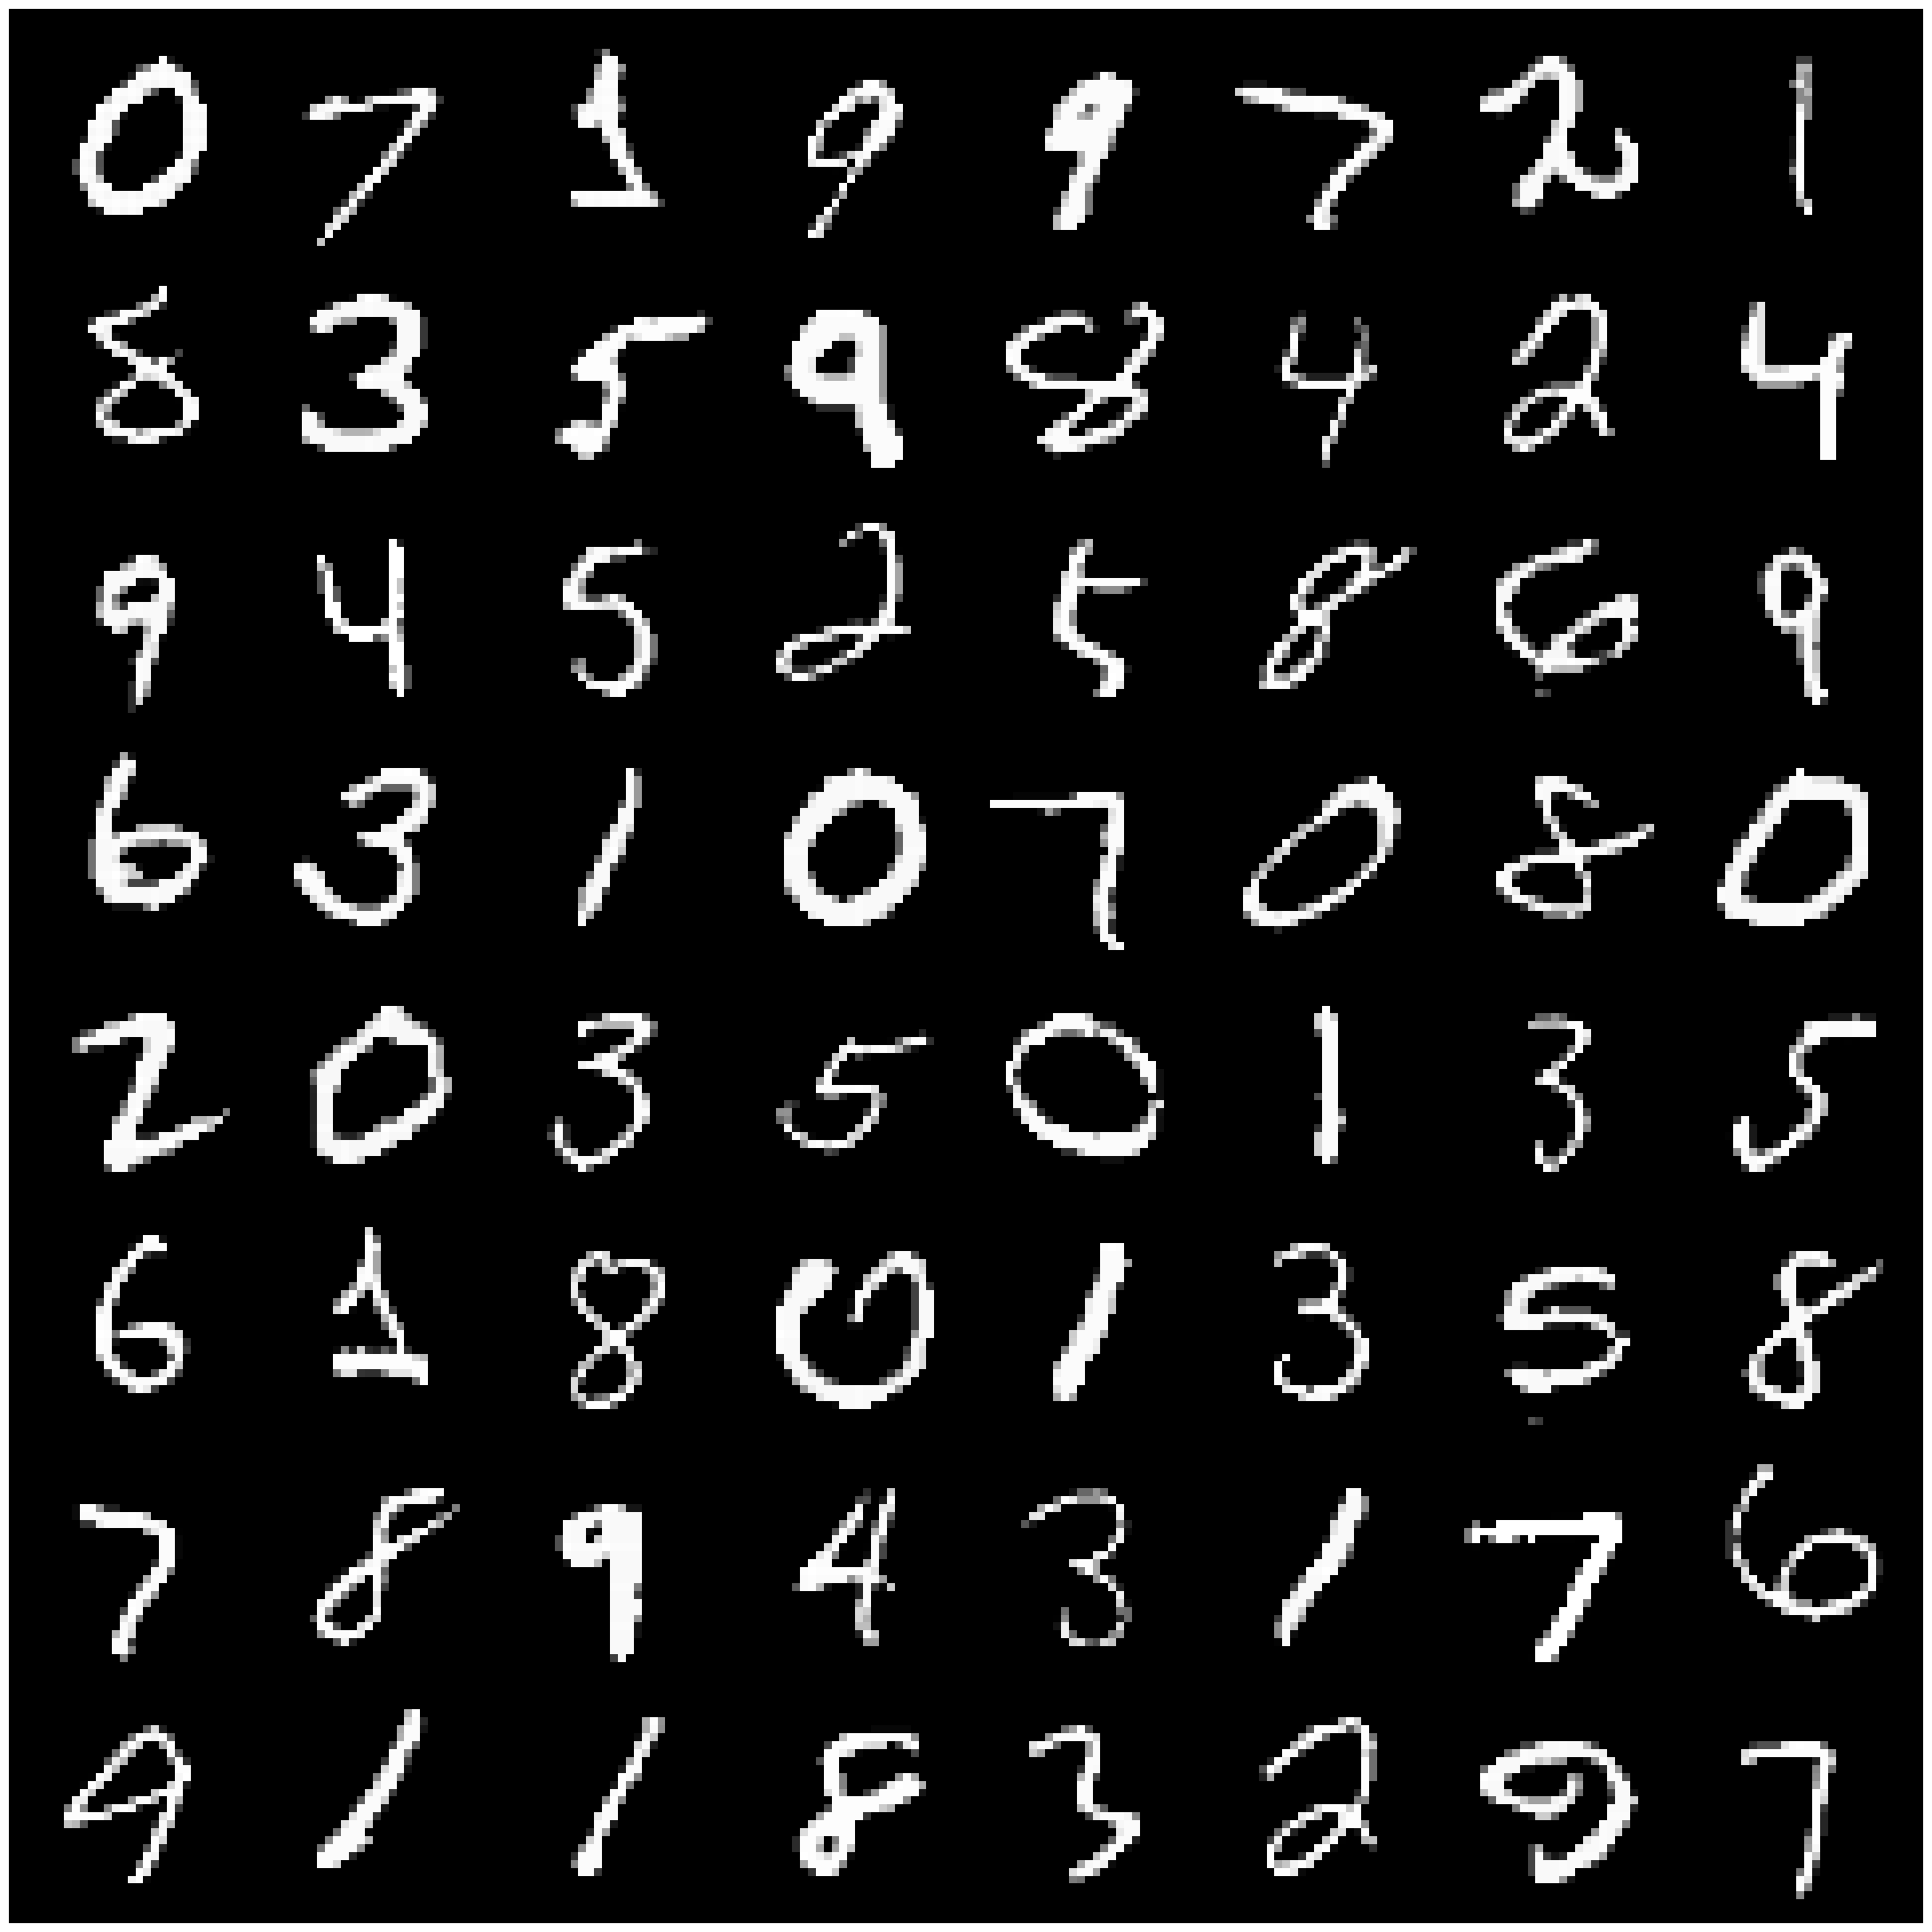

[0, 7, 1, 9, 9, 7, 2, 1, 8, 3, 5, 9, 8, 4, 2, 4, 9, 4, 5, 2, 5, 8, 6, 9, 6, 3, 1, 0, 7, 0, 8, 0, 2, 0, 3, 5, 0, 1, 3, 5, 6, 1, 8, 0, 1, 3, 5, 8, 7, 8, 9, 4, 3, 1, 7, 6, 9, 1, 1, 8, 3, 2, 9, 7]


In [7]:
# get some random training images
data_iter = iter(train_loader)
images, labels = next(data_iter)

print(images.shape)

imshow(torchvision.utils.make_grid(images))
print([l.item() for l in labels])

In [8]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, 
                      out_channels=2, 
                      kernel_size=5, 
                      stride=1, 
                      padding=0
                      ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=2, 
                      out_channels=4, 
                      kernel_size=3, 
                      stride=1, 
                      padding=0
                      ),
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(4 * 5 * 5, 10),
        )
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.fc(x)
        return x
    

net = CNN()
summary(net, input_size=(batch_size, 1, 28, 28), device=device)

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [64, 10]                  --
├─Sequential: 1-1                        [64, 2, 12, 12]           --
│    └─Conv2d: 2-1                       [64, 2, 24, 24]           52
│    └─ReLU: 2-2                         [64, 2, 24, 24]           --
│    └─MaxPool2d: 2-3                    [64, 2, 12, 12]           --
├─Sequential: 1-2                        [64, 4, 5, 5]             --
│    └─Conv2d: 2-4                       [64, 4, 10, 10]           76
│    └─Sigmoid: 2-5                      [64, 4, 10, 10]           --
│    └─MaxPool2d: 2-6                    [64, 4, 5, 5]             --
├─Sequential: 1-3                        [64, 10]                  --
│    └─Flatten: 2-7                      [64, 100]                 --
│    └─Linear: 2-8                       [64, 10]                  1,010
Total params: 1,138
Trainable params: 1,138
Non-trainable params: 0
Total mult-add

In [9]:
net = CNN()
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.AdamW(net.parameters(), lr=0.001)

net = net.to(device)
epoch_losses = []  # list to store running loss values for each epoch
epoch_accuracies = []  # list to store validation accuracy for each epoch
total_epochs = 30

best_model = None
best_val_accuracy = 0.0

for epoch in tqdm(range(total_epochs), total=total_epochs):  # loop over the dataset multiple 
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.to(device))
        loss = criterion(outputs.cpu(), labels)
        loss.backward()
        optimizer.step()

        # calculate training accuracy
        _, predicted = outputs.cpu().max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        # print statistics
        running_loss += loss.item()
    epoch_losses.append(running_loss / (i + 1))  # calculate mean running loss for the epoch
    epoch_accuracies.append(100 * correct / total)  # calculate validation accuracy for the epoch
    print(f'Epoch {epoch + 1}/{total_epochs}')
    print(f'Train loss: {running_loss / (i + 1):.3f}, accuracy: {100 * correct / total:.2f}%')
    running_loss = 0.0

    # Validation step
    net.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = val_data
            val_outputs = net(val_inputs.to(device))
            val_loss += criterion(val_outputs.cpu(), val_labels).item()
            _, val_predicted = val_outputs.cpu().max(1)
            val_total += val_labels.size(0)
            val_correct += val_predicted.eq(val_labels).sum().item()
    val_loss /= len(val_loader)
    val_accuracy = 100 * val_correct / val_total

    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model = net.state_dict()
    print(f'Validation loss: {val_loss:.3f}, accuracy: {val_accuracy:.2f}%')

print('Finished Training')

mean_epoch_loss = np.mean(epoch_losses)  # calculate mean of epoch losses
mean_epoch_accuracy = np.mean(epoch_accuracies)  # calculate mean of epoch accuracies
print(f'Mean running loss of every epoch: {mean_epoch_loss:.3f}')
print(f'Mean validation accuracy of every epoch: {mean_epoch_accuracy:.2f}%')

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1/30
Train loss: 1.318, accuracy: 65.84%


  3%|▎         | 1/30 [00:08<04:08,  8.57s/it]

Validation loss: 0.543, accuracy: 88.22%
Epoch 2/30
Train loss: 0.416, accuracy: 89.88%


  7%|▋         | 2/30 [00:17<03:58,  8.51s/it]

Validation loss: 0.329, accuracy: 91.71%
Epoch 3/30
Train loss: 0.296, accuracy: 92.16%


 10%|█         | 3/30 [00:25<03:46,  8.38s/it]

Validation loss: 0.254, accuracy: 93.36%
Epoch 4/30
Train loss: 0.243, accuracy: 93.42%


 13%|█▎        | 4/30 [00:33<03:37,  8.37s/it]

Validation loss: 0.218, accuracy: 94.13%
Epoch 5/30
Train loss: 0.211, accuracy: 94.20%


 17%|█▋        | 5/30 [00:42<03:30,  8.41s/it]

Validation loss: 0.189, accuracy: 94.73%
Epoch 6/30
Train loss: 0.190, accuracy: 94.67%


 20%|██        | 6/30 [00:50<03:22,  8.42s/it]

Validation loss: 0.173, accuracy: 95.18%
Epoch 7/30
Train loss: 0.175, accuracy: 95.04%


 23%|██▎       | 7/30 [00:58<03:13,  8.41s/it]

Validation loss: 0.162, accuracy: 95.25%
Epoch 8/30
Train loss: 0.163, accuracy: 95.29%


 27%|██▋       | 8/30 [01:07<03:03,  8.35s/it]

Validation loss: 0.150, accuracy: 95.64%
Epoch 9/30
Train loss: 0.155, accuracy: 95.54%


 30%|███       | 9/30 [01:15<02:56,  8.39s/it]

Validation loss: 0.143, accuracy: 95.78%
Epoch 10/30
Train loss: 0.147, accuracy: 95.76%


 33%|███▎      | 10/30 [01:23<02:47,  8.36s/it]

Validation loss: 0.137, accuracy: 95.88%
Epoch 11/30
Train loss: 0.141, accuracy: 95.86%


 37%|███▋      | 11/30 [01:32<02:39,  8.39s/it]

Validation loss: 0.134, accuracy: 96.06%
Epoch 12/30
Train loss: 0.136, accuracy: 95.95%


 40%|████      | 12/30 [01:40<02:31,  8.39s/it]

Validation loss: 0.130, accuracy: 96.05%
Epoch 13/30
Train loss: 0.132, accuracy: 96.15%


 43%|████▎     | 13/30 [01:49<02:23,  8.42s/it]

Validation loss: 0.126, accuracy: 96.18%
Epoch 14/30
Train loss: 0.129, accuracy: 96.18%


 47%|████▋     | 14/30 [01:58<02:17,  8.60s/it]

Validation loss: 0.125, accuracy: 96.20%
Epoch 15/30
Train loss: 0.126, accuracy: 96.28%


 50%|█████     | 15/30 [02:07<02:10,  8.68s/it]

Validation loss: 0.122, accuracy: 96.34%
Epoch 16/30
Train loss: 0.123, accuracy: 96.35%


 53%|█████▎    | 16/30 [02:16<02:02,  8.76s/it]

Validation loss: 0.119, accuracy: 96.51%
Epoch 17/30
Train loss: 0.120, accuracy: 96.42%


 57%|█████▋    | 17/30 [02:24<01:53,  8.74s/it]

Validation loss: 0.118, accuracy: 96.51%
Epoch 18/30
Train loss: 0.118, accuracy: 96.51%


 60%|██████    | 18/30 [02:33<01:44,  8.73s/it]

Validation loss: 0.115, accuracy: 96.53%
Epoch 19/30
Train loss: 0.116, accuracy: 96.58%


 63%|██████▎   | 19/30 [02:42<01:35,  8.69s/it]

Validation loss: 0.113, accuracy: 96.61%
Epoch 20/30
Train loss: 0.114, accuracy: 96.61%


 67%|██████▋   | 20/30 [02:50<01:26,  8.65s/it]

Validation loss: 0.112, accuracy: 96.53%
Epoch 21/30
Train loss: 0.112, accuracy: 96.68%


 70%|███████   | 21/30 [02:59<01:18,  8.71s/it]

Validation loss: 0.113, accuracy: 96.56%
Epoch 22/30
Train loss: 0.110, accuracy: 96.70%


 73%|███████▎  | 22/30 [03:08<01:09,  8.73s/it]

Validation loss: 0.109, accuracy: 96.76%
Epoch 23/30
Train loss: 0.108, accuracy: 96.75%


 77%|███████▋  | 23/30 [03:17<01:01,  8.76s/it]

Validation loss: 0.106, accuracy: 96.89%
Epoch 24/30
Train loss: 0.107, accuracy: 96.81%


 80%|████████  | 24/30 [03:25<00:52,  8.73s/it]

Validation loss: 0.105, accuracy: 96.89%
Epoch 25/30
Train loss: 0.105, accuracy: 96.90%


 83%|████████▎ | 25/30 [03:34<00:43,  8.72s/it]

Validation loss: 0.104, accuracy: 96.99%
Epoch 26/30
Train loss: 0.104, accuracy: 96.96%


 87%|████████▋ | 26/30 [03:43<00:35,  8.78s/it]

Validation loss: 0.103, accuracy: 96.99%
Epoch 27/30
Train loss: 0.102, accuracy: 96.93%


 90%|█████████ | 27/30 [03:52<00:26,  8.82s/it]

Validation loss: 0.102, accuracy: 97.06%
Epoch 28/30
Train loss: 0.101, accuracy: 96.96%


 93%|█████████▎| 28/30 [04:01<00:17,  8.80s/it]

Validation loss: 0.100, accuracy: 97.10%
Epoch 29/30
Train loss: 0.100, accuracy: 97.00%


 97%|█████████▋| 29/30 [04:09<00:08,  8.78s/it]

Validation loss: 0.102, accuracy: 96.92%
Epoch 30/30
Train loss: 0.099, accuracy: 97.08%


100%|██████████| 30/30 [04:18<00:00,  8.62s/it]

Validation loss: 0.099, accuracy: 97.12%
Finished Training
Mean running loss of every epoch: 0.187
Mean validation accuracy of every epoch: 94.78%


In [11]:
# save best_model
os.makedirs('./models', exist_ok=True)
torch.save(best_model, './models/best_model.pth')

In [10]:
# Validation step
net = CNN()
net.load_state_dict(best_model)
net = net.to(device)

net.eval()  # Set the model to evaluation mode
val_loss = 0.0
val_correct = 0
val_total = 0
with torch.no_grad():
    for val_data in val_loader:
        val_inputs, val_labels = val_data
        val_outputs = net(val_inputs.to(device))
        val_loss += criterion(val_outputs.cpu(), val_labels).item()
        _, val_predicted = val_outputs.cpu().max(1)
        val_total += val_labels.size(0)
        val_correct += val_predicted.eq(val_labels).sum().item()
val_loss /= len(val_loader)
val_accuracy = 100 * val_correct / val_total

print(f'Validation loss: {val_loss:.3f}, accuracy: {val_accuracy:.2f}%')

Validation loss: 0.099, accuracy: 97.12%


In [12]:
# Test step
net = CNN()
net.load_state_dict(best_model)
net = net.to(device)

# Test step
net.eval()  # Set the model to evaluation mode
test_loss = 0.0
test_correct = 0
test_total = 0

with torch.no_grad():
    for test_data in test_loader:
        test_inputs, test_labels = test_data
        test_outputs = net(test_inputs.to(device))
        test_loss += criterion(test_outputs.cpu(), test_labels).item()
        _, test_predicted = test_outputs.cpu().max(1)
        test_total += test_labels.size(0)
        test_correct += test_predicted.eq(test_labels).sum().item()
test_loss /= len(test_loader)
test_accuracy = 100 * test_correct / test_total
print(f'Test loss: {test_loss:.3f}, accuracy: {test_accuracy:.2f}%')

Test loss: 0.094, accuracy: 96.98%


torch.Size([2, 12, 12])


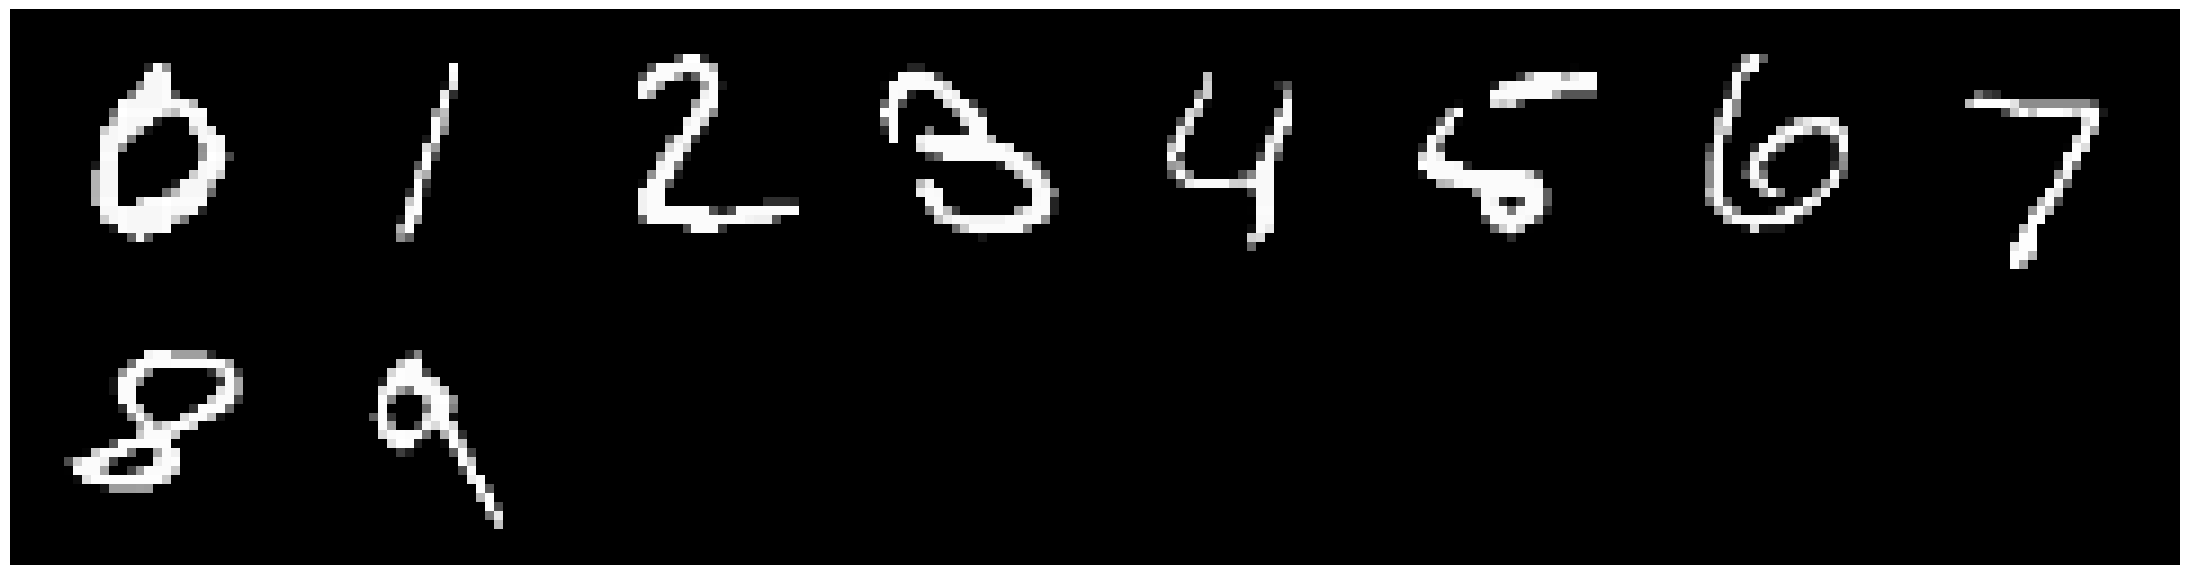

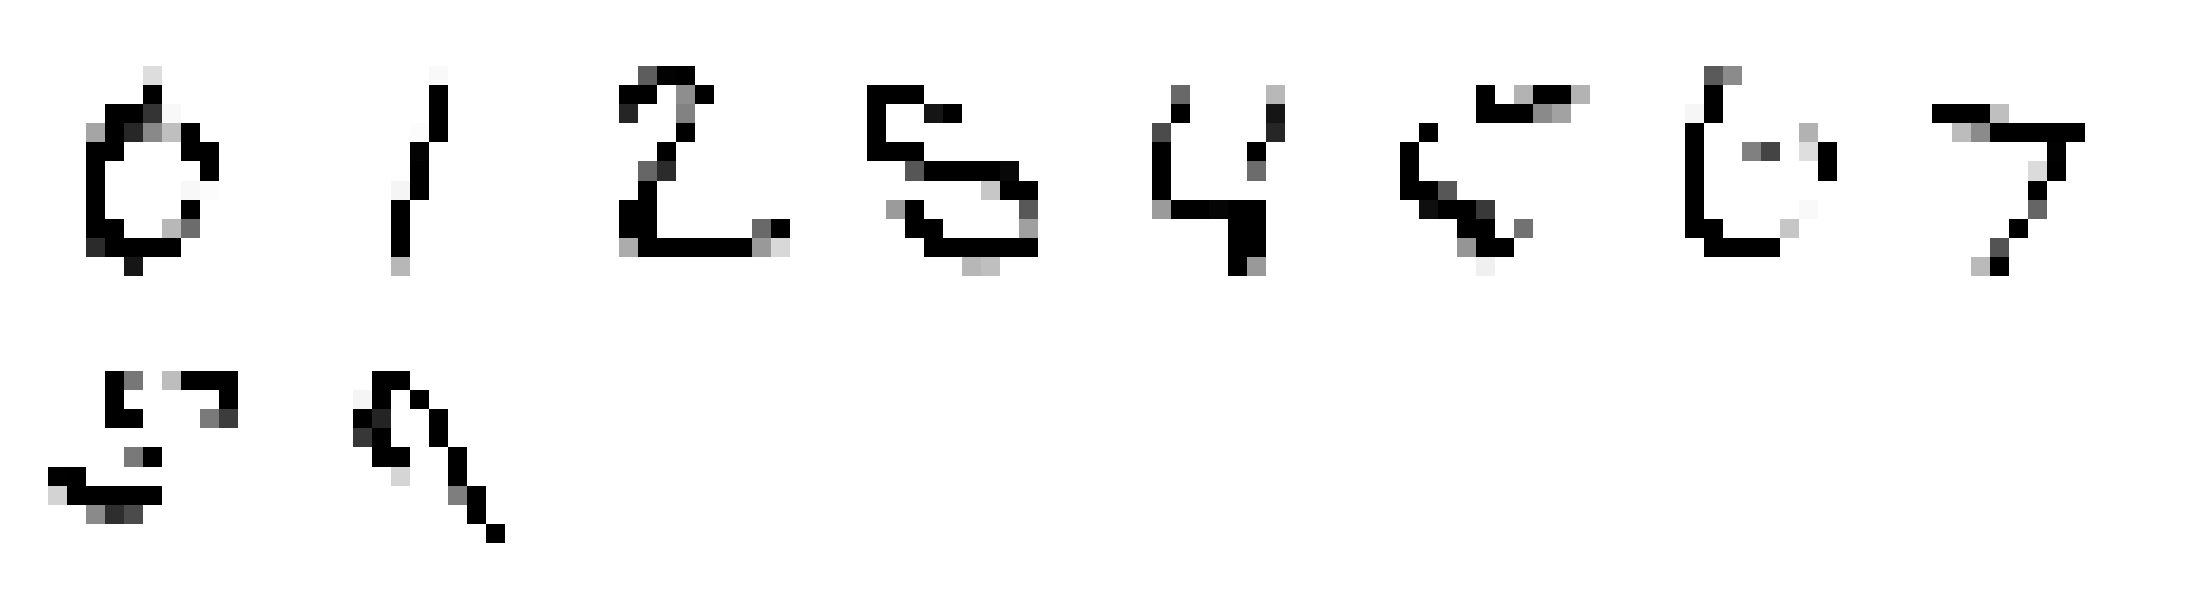

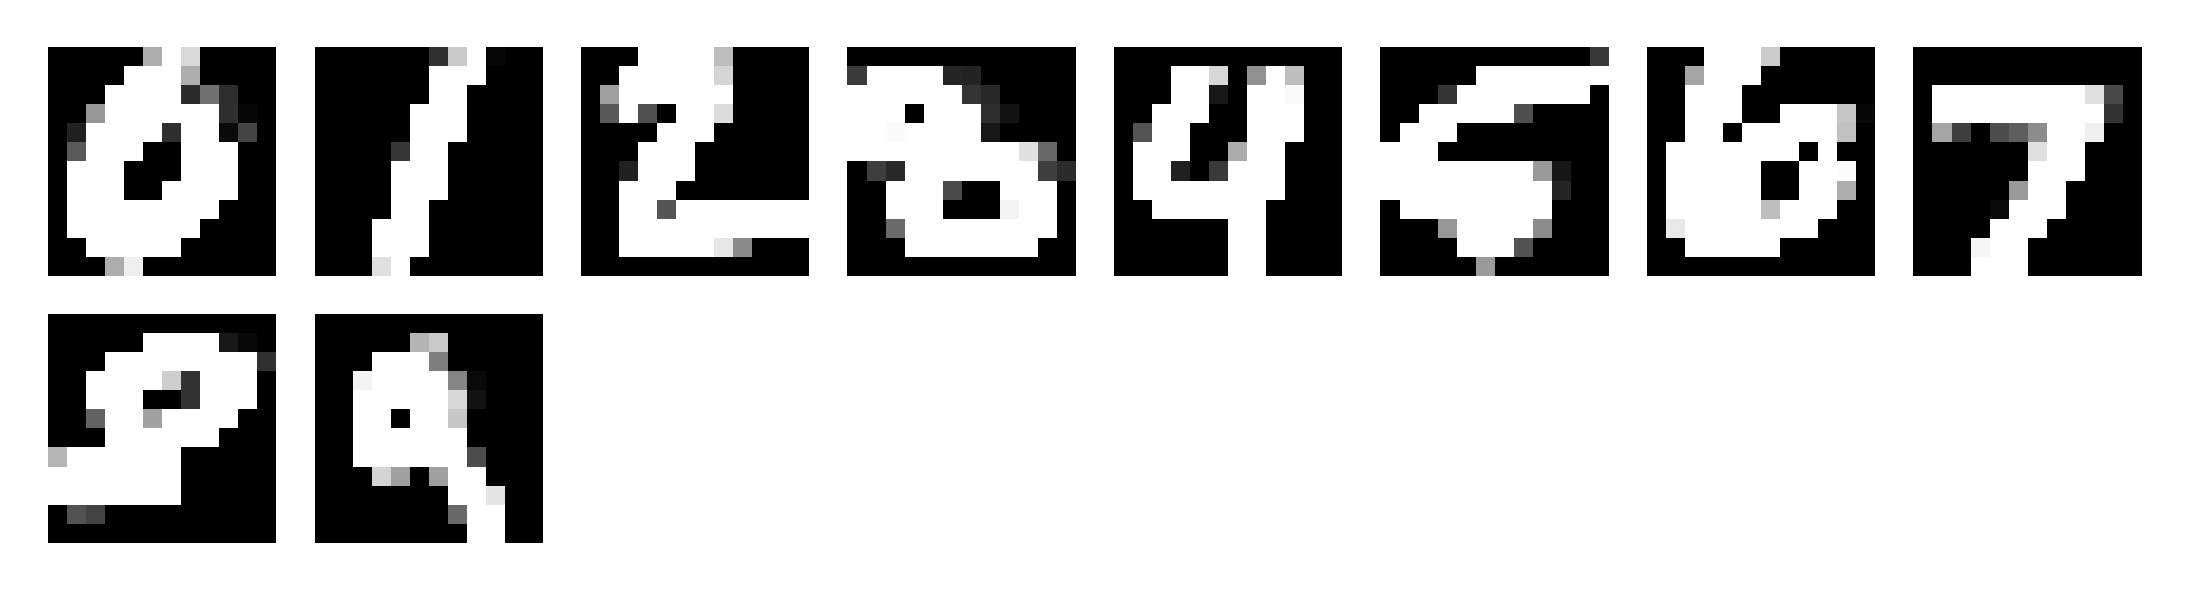

In [14]:
# get a sample of each class in the test set
classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
class_samples = []

for cls in classes:
    for i in range(len(test_dataset)):
        if test_dataset[i][1] == int(cls):
            class_samples.append(test_dataset[i])
            break

# pass each class sample over the first convolutional layer
net.eval()
conv1_outputs = []
for img, label in class_samples:
    img = img.unsqueeze(0)
    output = net.conv1(img.to(device))
    # output = net.conv2(output)
    conv1_outputs.append(output.cpu().detach())
print(conv1_outputs[0].squeeze(0).size())

first_feature_map = [im[:, 0, :, :] for im in conv1_outputs]
second_feature_map = [im[:, 1, :, :] for im in conv1_outputs]

# show the outputs of the first convolutional layer
imshow(torchvision.utils.make_grid([img for (img, label) in class_samples]))

n_channels = conv1_outputs[0].size()[1]

for i in range(n_channels):
    imshow(torchvision.utils.make_grid([im[:, i, :, :] for im in conv1_outputs], pad_value=1))